# ***QA-VAC NOTEBOOK - Region Selection Plots***

Author: Gabriel Luan Souza de Oliveira.

Last update: 16/03/2022.

## ***Imported Modules***

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from astropy.table import Table
import healpy as hp
import copy
from gavodb import DBManager

## ***Loading Data***

### Loading Function

In [2]:
%reload_ext autoreload
def table_loading(pid, ntable, columns = None, limit = False,verbose = False,
                  indexs = None, column_indexs_name = None, footprint_table_name = None, sorting_column = None):
    ''' Assign a table from a especific process to a variable using DBManager from gavodb.py. 
        The rows and columns of the table can be altered according to the args options.
    
    Args:
    -----
        pid (int): process id on DES Science Portal.
        ntable (int): each process id can contain more than one table associated. So you can choose what you want.
        columns (string array or None): the columns to add to the table. If None, all columns will be added to the table.
        limit (integer or False): number of rows to add to the table. If False, all rows will be added.
        verbose (bool): Print some infos.
        
        indexs (array): array with values from "column_indexs_name" column that are desired to be select. It's very slow for big arrays.
        column_indexs_name (str): the name of the column that you want to use to select rows with "indexs" values.
        - None for both this args gives the complete table.
        
        footprint_table_name (str): name of the footprint table used for select rows of the table.
        sorting_column (str): name of the commom column for both table and footprint table utilized to select rows.
    
    Returns:
        table_cool (astropy table): the desired table.
    
    Obs: 
    ----
        Make sure that gavodb contains gabolv_features in the end of the script.
    '''
    dbm = DBManager()
    pid_tables = dbm.get_tablelist_from_pid(pid)
    table_name = dbm.get_tablelist_from_pid(pid)[int(ntable)]
    
    if columns == None: columns = dbm.get_db_table_columns_names(table_name)
        
    table = dbm.get_db_table_new(table_name, columns, 
                                 limit = limit, indexs = indexs, column_indexs_name = column_indexs_name,
                                 footprint_table_name = footprint_table_name, sorting_column = sorting_column)
    
    table_cool = Table(rows=table.T, names=columns)

    if verbose == True:
        print(f'Tables in pid {pid}:', pid_tables)
        print(f'\nTable chosen:',table_name)
        print(f'\nColumns of table {table_name}: = ', columns,'\n')
        print(table_cool)
        print('\nDone!')
    
    return table_cool

### Detection fraction table

In [3]:
%%time
pids = ['6617', '6618', '6619', '6620', '6621'] # grizY bands
det_frac_table = table_loading(pids[2],0,None,False,False)

CPU times: user 3.43 s, sys: 119 ms, total: 3.55 s
Wall time: 4.12 s


### N-images table

In [4]:
%%time
pids = ['6622', '6623', '6624', '6625', '6626'] # grizY bands
n_images_table = table_loading(pids[2],0,None,False, False)

CPU times: user 3.38 s, sys: 113 ms, total: 3.49 s
Wall time: 4.12 s


### Foreground objects mask table

In [5]:
%%time
pid = '6627'
fore_obj_mask_table = table_loading(pid,0,None,False,False)
#1 - Gaia bright stars; #2 - Yale bright stars; #4 - 2MASS bright stars; #8 - Gaia mid stars; 
#16 - 2MASS faint stars; #32 - Large nearby galaxy (HyperLEDA catalog); #64 - Globular clusters; #128 - Near the LMC 

CPU times: user 116 ms, sys: 8.11 ms, total: 124 ms
Wall time: 157 ms


### Footprint table

In [6]:
%%time
pid = '6838'
footprint_table = table_loading(pid,0,None,False,False)

ra,dec = hp.pix2ang(nside=4096, ipix=footprint_table['pixel'], lonlat = True, nest = True)
ra[ra>180] -= 360

footprint_table['ra'] = ra
footprint_table['dec'] = dec

CPU times: user 3.66 s, sys: 127 ms, total: 3.79 s
Wall time: 4.28 s


### Depth tables

In [7]:
%%time
dbm = DBManager()
footprint_table_name = dbm.get_tablelist_from_pid('6838')[0]
sorting_column = 'pixel'
depth_band = 'z'
depth_band_dict = {'i': 0, 'r': 1, 'z': 2}

#sn5
pid = '6710'
depth_table_sn5 = table_loading(pid, depth_band_dict[depth_band], columns = None, verbose = False,
                               footprint_table_name = footprint_table_name, sorting_column = sorting_column)

ra,dec = hp.pix2ang(nside=4096, ipix=depth_table_sn5['pixel'].astype(int), lonlat = True, nest = True)
ra[ra>180] -= 360

depth_table_sn5['ra'] = ra
depth_table_sn5['dec'] = dec

#sn10
pid = '6787'
depth_table_sn10 = table_loading(pid, depth_band_dict[depth_band], columns = None, verbose = False,
                               footprint_table_name = footprint_table_name, sorting_column = sorting_column)

ra_2,dec_2 = hp.pix2ang(nside=4096, ipix=depth_table_sn5['pixel'].astype(int), lonlat = True, nest = True)
ra_2[ra_2>180] -= 360

depth_table_sn10['ra'] = ra_2
depth_table_sn10['dec'] = dec_2

select a.pixel, a.signal from depth_maps.y6a2_gold_sof_bdf_corrected_4096_nest_z_6710 a inner join vac_cluster.footprint_6838 b on a.pixel = b.pixel 

select a.pixel, a.signal from depth_maps.y6a2_gold_sof_bdf_corrected_4096_nest_z_6787 a inner join vac_cluster.footprint_6838 b on a.pixel = b.pixel 

CPU times: user 6.4 s, sys: 123 ms, total: 6.53 s
Wall time: 9.49 s


### Effective Area

In [8]:
%%time
nside = 4096
steradian_in_degrees = (180./np.pi)**2
sky_area = 4*np.pi*steradian_in_degrees   #Area of an sphere measured in degrees^2. Read more on https://www.mathsisfun.com/geometry/steradian.html
npixels = hp.nside2npix(nside)            #Númeto de pixeis em um Healpix pixelization scheme => 12.0*(nside)**2.0
area_of_each_pixel = sky_area/(npixels)   #In degrees^2.
pix_area_arcmin = 3600*area_of_each_pixel

pixel_effective_area_dummy = np.ones_like(det_frac_table['pixel'])*pix_area_arcmin
pixel_effective_area = pixel_effective_area_dummy*np.array(det_frac_table['signal'])

det_frac_table['effective_pixel_area'] = pixel_effective_area

CPU times: user 1.51 ms, sys: 2.49 ms, total: 4 ms
Wall time: 3.44 ms


## ***Plots***

### Plot Functions

In [9]:
%reload_ext autoreload
def mask_func(signal,mask_dict):
    if mask_dict != None:
        assert mask_dict['relation'] in ('less','greater','equal'), 'Input key is not a valid string.'
        #assert type(signal).__name__ == 'ndarray', 'signal must be an numpy array (ndarray)'

        if mask_dict['relation'] == 'less':
            mask = signal < mask_dict['value']

        elif mask_dict['relation'] == 'greater':
            mask = signal > mask_dict['value']

        elif mask_dict['relation'] == 'equal':
            mask = signal == mask_dict['value']
    else:
         mask = signal == signal   
    return mask

def plot_map(ra,dec,signal, verbose = False, map_type = 'cartesian',**kwargs):

    ###-------------------------------------------###
    #                Key informations               #
    ###-------------------------------------------###
    
    nside = 4096
    steradian_in_degrees = (180./np.pi)**2
    sky_area = 4*np.pi*steradian_in_degrees   #Area of an sphere measured in degrees^2. Read more on https://www.mathsisfun.com/geometry/steradian.html
    npixels = hp.nside2npix(nside)            #Númeto de pixeis em um Healpix pixelization scheme => 12.0*(nside)**2.0
    area_of_each_pixel = sky_area/(npixels)   #In degrees^2.
    pix_area_arcmin = 3600*area_of_each_pixel #Pixel area in (minutes of degree)².
    
    if verbose == True:
        print('Number of pixels:',npixels,
              '\nSky area:', sky_area,'degrees²',
              '\nArea of each pixel:', area_of_each_pixel, 'degrees²;', pix_area_arcmin,'min^2')
    
    ###-------------------------------------------###
    #                     Mask                      #
    ###-------------------------------------------###
    mask = mask_func(signal, kwargs['mask_dict'])
    
    ###-------------------------------------------###
    #                     Plot                      #
    ###-------------------------------------------###
    
    if map_type == 'cartesian':
        
        # Fig config
        plt.clf()
        fig, ax = plt.subplots(1, figsize = (16,9))
        ax.set_facecolor('#696969')
    
        # To plot
        sc = ax.scatter(ra[mask], dec[mask], c = signal[mask],
                        vmin = kwargs['vmin'], vmax = kwargs['vmax'], cmap = kwargs['cmap'], 
                        marker = kwargs['marker'], s=kwargs['marker_size'], linewidths=kwargs['marker_linewidths'])

        # Axis Stuff
        ax.set_xlim(30,40)
        ax.set_ylim(-9,-2)
        ax.invert_xaxis()

        # Labels
        ax.set_xlabel('R.A. (degrees)', fontsize = 16)
        ax.set_ylabel('DEC. (degrees)', fontsize = 16)
        ax.set_title(kwargs['title'], fontsize = 20, weight='bold')
        ax.tick_params(axis='both', which='major', labelsize=16)

        # Colorbar
        if kwargs['colorbar'] == True:
            cbar = fig.colorbar(sc, ax = [ax], location = 'right', pad = 0)
            cbar.set_label(kwargs['barlabel'], fontsize = 16, labelpad = 12.0)
            cbar.set_ticks(kwargs['setticks'])
            cbar.ax.tick_params(labelsize=16)

        plt.show()  

### Detection Fraction Map (grizY bands)

<Figure size 432x288 with 0 Axes>

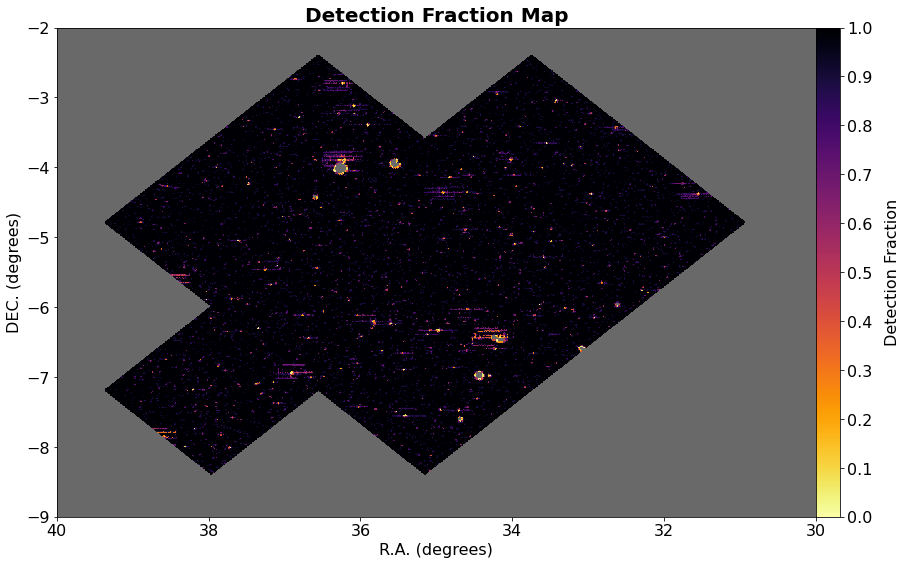

In [10]:
params = {'title':f"Detection Fraction Map",
          'barlabel':"Detection Fraction",
          'vmin':0,
          'vmax':1,
          'cmap':cm.inferno_r,
          'setticks':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'mask_dict': {'relation': 'greater', 'value':0},
          'colorbar': True,
          'marker':',',
          'marker_size':1.0,
          'marker_linewidths':1.0
         }

plot_map(det_frac_table['ra'], det_frac_table['dec'], det_frac_table['signal'],'cartesian', **params)

### N-images Map (grizY bands)

<Figure size 432x288 with 0 Axes>

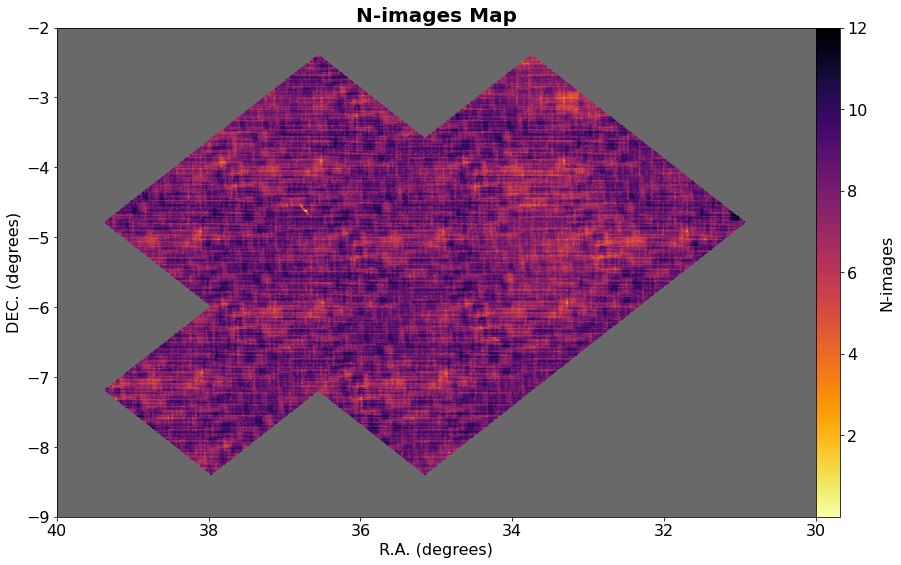

In [11]:
params = {'title':f"N-images Map",
          'barlabel':"N-images",
          'vmin':0,
          'vmax':12,
          'cmap':cm.inferno_r,
          'setticks':[2,4,6,8,10,12],
          'mask_dict': {'relation': 'greater', 'value':1},
          'colorbar': True,
          'marker':',',
          'marker_size':1.0,
          'marker_linewidths':1.0
         }
plot_map(n_images_table['ra'],n_images_table['dec'],n_images_table['signal'],'cartesian', **params)

### Foreground objects mask map

<Figure size 432x288 with 0 Axes>

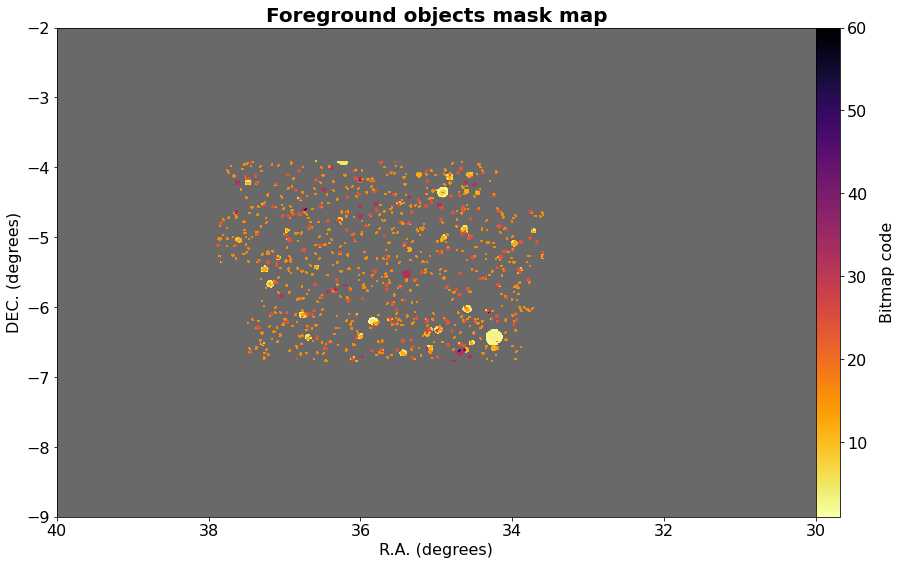

In [12]:
params = {'title':f"Foreground objects mask map",
          'barlabel':"Bitmap code",
          'vmin':1,
          'vmax':60,
          'cmap':cm.inferno_r,
          'setticks':[0,10,20,30,40,50,60],
          'mask_dict': {'relation': 'greater', 'value':0},
          'colorbar': True,
          'marker':',',
          'marker_size':1.0,
          'marker_linewidths':1.0
         }

plot_map(fore_obj_mask_table['ra'],fore_obj_mask_table['dec'],fore_obj_mask_table['signal'],'cartesian', **params)

### Footprint Map

<Figure size 432x288 with 0 Axes>

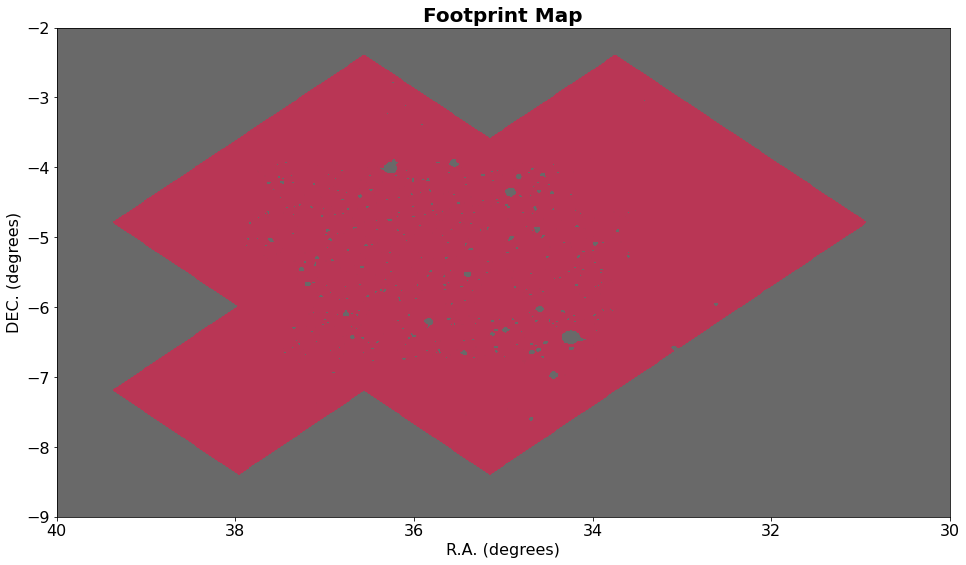

In [13]:
params = {'title':f"Footprint Map",
          'barlabel':"Signal",
          'vmin':0,
          'vmax':2,
          'cmap':cm.inferno_r,
          'setticks':[0,1,2],
          'mask_dict': {'relation': 'greater', 'value':0},
          'colorbar': False,
          'marker':',',
          'marker_size':1.0,
          'marker_linewidths':1.0
         }

plot_map(footprint_table['ra'],footprint_table['dec'], footprint_table['signal'],'cartesian', **params)

### Depth Maps

<Figure size 432x288 with 0 Axes>

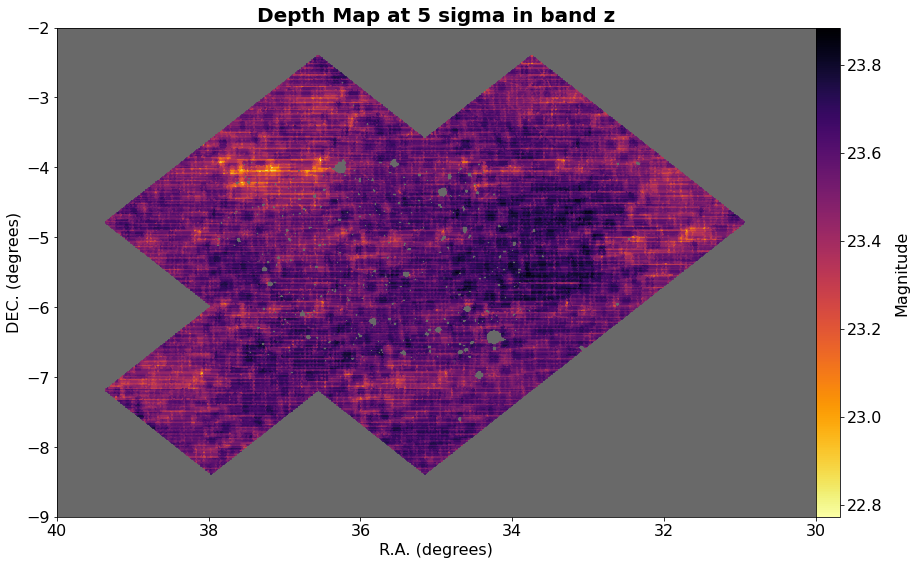

In [14]:
params = {'title':f"Depth Map at 5 sigma in band {depth_band}",
          'barlabel':"Magnitude",
          'vmin':None,
          'vmax':None,
          'cmap':cm.inferno_r,
          'setticks':None,
          'mask_dict': {'relation': 'greater', 'value':21.5},
          'colorbar': True,
          'marker':',',
          'marker_size':1.0,
          'marker_linewidths':0.7
         }
plot_map(depth_table_sn5['ra'],depth_table_sn5['dec'],depth_table_sn5['signal'], **params)

<Figure size 432x288 with 0 Axes>

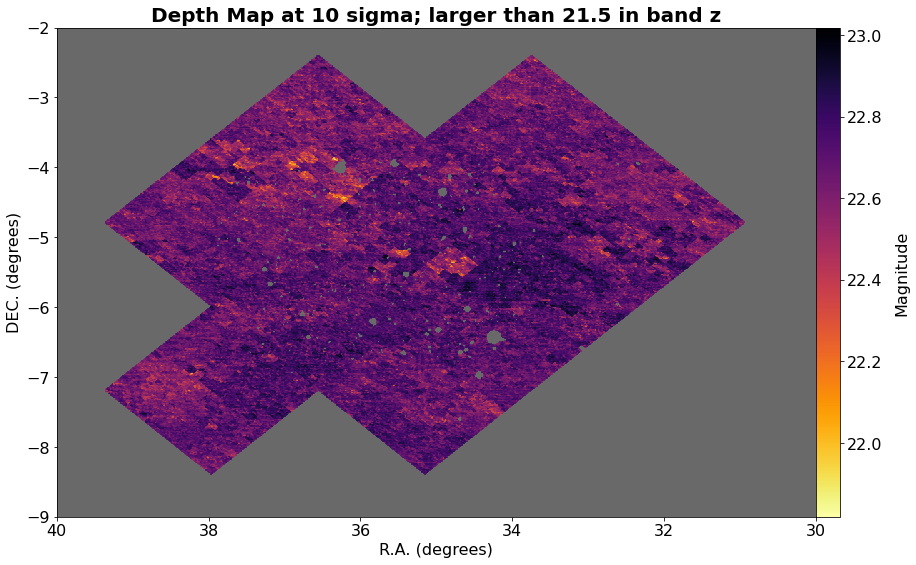

In [15]:
params = {'title':f"Depth Map at 10 sigma; larger than 21.5 in band {depth_band}",
          'barlabel':"Magnitude",
          'vmin':None,
          'vmax':None,
          'cmap':cm.inferno_r,
          'setticks':None,
          'mask_dict': {'relation': 'greater', 'value': 21.5},
          'colorbar': True,
          'marker':',',
          'marker_size':1.0,
          'marker_linewidths':0.7
         }
plot_map(depth_table_sn10['ra'],depth_table_sn10['dec'],depth_table_sn10['signal'], **params)

### Effective area map

<Figure size 432x288 with 0 Axes>

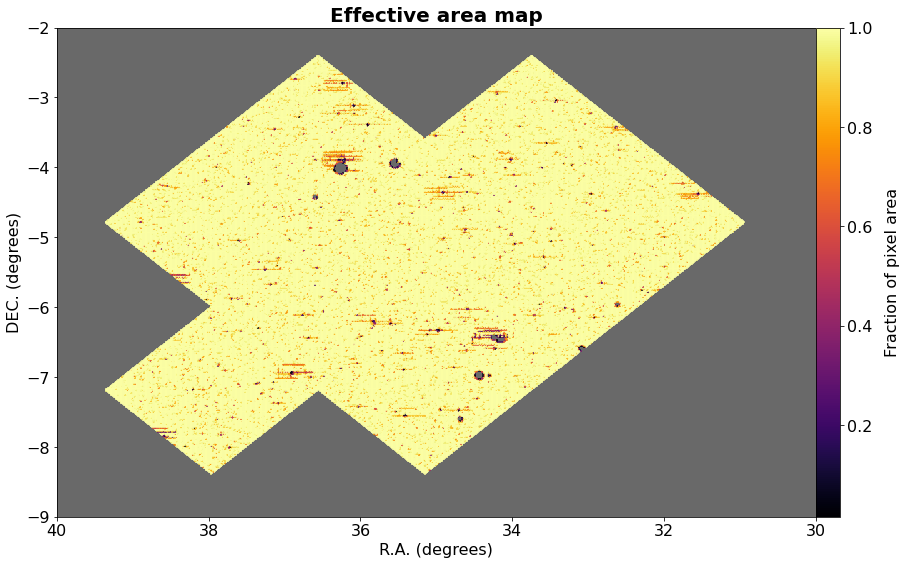

Total footprint area: 30.13506782566306 degrees
Effective total area: 21.842021600073487 degrees


In [16]:
params = {'title':f"Effective area map",
          'barlabel':"Fraction of pixel area",
          'vmin':None,
          'vmax':None,
          'cmap':cm.inferno,
          'setticks':None,
          'mask_dict': None,
          'colorbar': True,
          'marker':',',
          'marker_size':1.0,
          'marker_linewidths':0.7
         }
plot_map(det_frac_table['ra'],det_frac_table['dec'],det_frac_table['effective_pixel_area']/pix_area_arcmin, **params)
print('Total footprint area:', len(det_frac_table['effective_pixel_area'])*pix_area_arcmin/3600, 'degrees')
print('Effective total area:', np.sum(det_frac_table['effective_pixel_area'])*pix_area_arcmin/3600, 'degrees')